In [1]:
# Imports & Settings
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
import matplotlib.pyplot as plt

# Reproducibility
seed        = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Hyperparameters
data_path   = "Cleaned_Tickets.csv"
pretrained  = "microsoft/deberta-v3-large"
batch_size  = 16
max_length  = 256
lr          = 2e-5
num_epochs  = 10
patience    = 2
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Threshold grid for tuning
threshold_grid = np.linspace(0.1, 0.9, 17)

c:\Users\chria\Documents\Μεταπτυχιακό\Deep Learning\tickets-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %% Load & Prepare Data
df = pd.read_csv(data_path)

In [3]:
# Combine subject + body
df["text"] = df["subject"].str.strip() + " " + df["body"].str.strip()

# Build list of tags
df["tags_list"] = df[["tag_1", "tag_2", "tag_3"]].values.tolist()
all_tags       = sorted({t for tags in df["tags_list"] for t in tags})

In [4]:
# Binarize tags
mlb = MultiLabelBinarizer(classes=all_tags)
y = mlb.fit_transform(df["tags_list"])    # shape = [N, num_tags]

In [5]:
# Train / Val / Test split
texts    = df["text"].tolist()

X_temp, X_test, y_temp, y_test = train_test_split(
    df["text"].tolist(), y,
    test_size=0.10, random_state=seed, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.10, random_state=seed, shuffle=True
)

In [6]:
# %% Tokenizer & Dataset
tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/deberta-v3-large",
    use_fast=False,
    do_lower_case=True   # if you want all lowercase inputs
)

class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts       = texts
        self.labels      = labels
        self.tokenizer   = tokenizer
        self.max_length  = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

train_ds = MultiLabelDataset(X_train, y_train, tokenizer, max_length)
val_ds   = MultiLabelDataset(X_val,   y_val,   tokenizer, max_length)
test_ds  = MultiLabelDataset(X_test,  y_test,  tokenizer, max_length)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

c:\Users\chria\Documents\Μεταπτυχιακό\Deep Learning\tickets-project\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chria\.cache\huggingface\hub\models--microsoft--deberta-v3-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [7]:
# %% Model, Loss, Optimizer, Scheduler
config    = AutoConfig.from_pretrained(
    pretrained,
    num_labels=len(all_tags),
    problem_type="multi_label_classification"
)
model     = AutoModelForSequenceClassification.from_pretrained( pretrained, config=config, weights_only=True)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=lr)

total_steps = len(train_loader) * num_epochs
scheduler   = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# %% Early Stopping
class EarlyStopping:
    def __init__(self, patience=patience, mode="max", delta=0.0):
        self.patience   = patience
        self.mode       = mode
        self.delta      = delta
        self.best       = None
        self.counter    = 0
        self.should_stop= False

    def step(self, metric):
        improved = (
            metric > self.best + self.delta
            if self.mode == "max"
            else metric < self.best - self.delta
        ) if self.best is not None else True

        if improved:
            self.best    = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

In [9]:
# %% Training & Evaluation Functions
def train_epoch():
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits  = outputs.logits
        loss    = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

def eval_model(loader, threshold=0.5):
    model.eval()
    total_loss = 0.0
    all_logits, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits  = outputs.logits
            loss    = criterion(logits, labels)
            total_loss += loss.item()

            all_logits .append(logits.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    logits   = np.vstack(all_logits)   # [N, num_tags]
    y_true   = np.vstack(all_labels)
    probs    = 1 / (1 + np.exp(-logits))
    y_pred   = (probs > threshold).astype(int)

    prec = precision_score(y_true, y_pred, average="micro", zero_division=0)
    rec  = recall_score   (y_true, y_pred, average="micro", zero_division=0)
    f1   = f1_score       (y_true, y_pred, average="micro", zero_division=0)
    return avg_loss, prec, rec, f1, logits, y_true

def tune_thresholds(val_logits, val_true):
    best_thresh = []
    for i in range(val_true.shape[1]):
        best_f1, best_t = 0, 0.5
        for t in threshold_grid:
            preds_i = (1/(1+np.exp(-val_logits[:,i])) > t).astype(int)
            f1_i    = f1_score(val_true[:,i], preds_i, zero_division=0)
            if f1_i > best_f1:
                best_f1, best_t = f1_i, t
        best_thresh.append(best_t)
    return np.array(best_thresh)

In [16]:
early_stopper = EarlyStopping()
best_f1       = -float("inf")
checkpoint    = "pretrained_tags_model_weights.pt"

train_losses, val_losses, val_f1s = [], [], []

In [ ]:
# %% Main Training Loop

for epoch in range(1, num_epochs+1):
    print(f"\n→ Epoch {epoch}", flush=True)
    tr_loss = train_epoch()
    train_losses.append(tr_loss)

    val_loss, val_prec, val_rec, val_f1, _, _ = eval_model(val_loader)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), checkpoint)
        print(f"  New best Val F1={best_f1:.4f} → checkpoint saved.")

    print(
        f"  Train Loss: {tr_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val F1: {val_f1:.4f} | "
        f"P: {val_prec:.4f} | R: {val_rec:.4f}"
    )

    early_stopper.step(val_f1)
    if early_stopper.should_stop:
        print("Early stopping triggered.")
        break


→ Epoch 1


KeyboardInterrupt: 

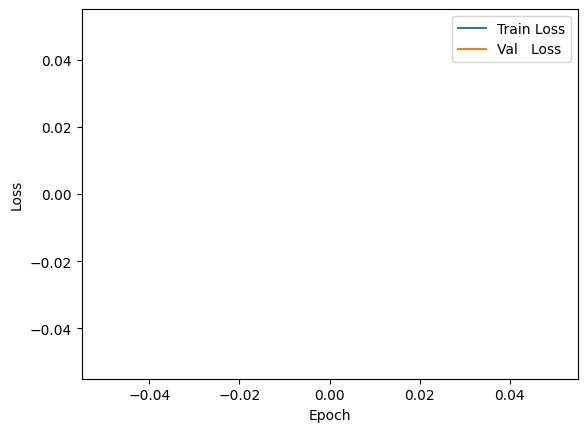

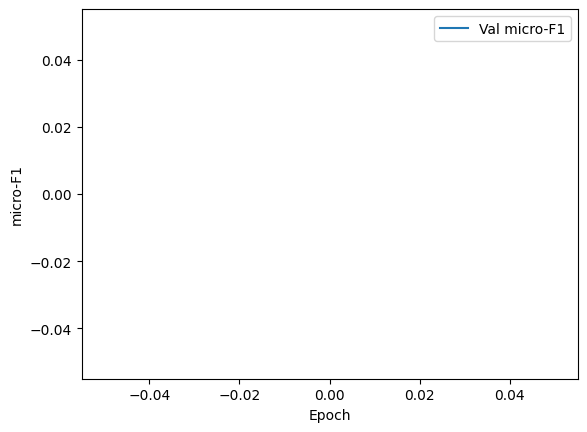

In [14]:
# Plot Loss & Val-F1
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1),   val_losses,   label="Val   Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.plot(range(1, len(val_f1s)+1), val_f1s, label="Val micro-F1")
plt.xlabel("Epoch"); plt.ylabel("micro-F1"); plt.legend(); plt.show()

In [17]:
# Threshold tuning on validation set
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()

val_logits_list, val_true_list = [], []
with torch.no_grad():
    for batch in val_loader:
        out = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        ).logits.cpu().numpy()
        val_logits_list.append(out)
        val_true_list .append(batch["labels"].cpu().numpy())

val_logits = np.vstack(val_logits_list)
val_true   = np.vstack(val_true_list)

best_thresh = tune_thresholds(val_logits, val_true)
print("Per-tag thresholds:", best_thresh)

Per-tag thresholds: [0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.75 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.8  0.5  0.5  0.5  0.1  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.25 0.5  0.5  0.3  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.2  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.4  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.15 0.25 0.5
 0.5  0.15 0.5  0.5  0.5  0.5  0.5  0.5  0.25 0.5  0.5  0.5  0.25 0.5
 0.5  0.5  0.5  0.5  0.5  0.15 0.5  0.5  0.5  0.5  0.4  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.2  0.5  0.4  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.2  0.5  0.5  0.5  0.5  0.1  0.5  0.5  0.5  0.5
 0.5  0.5  0.15 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.25 0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.4  0.75 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.1  0.5  0.5  0.5  0.15 0.5  0.8  0.5  0.5  0.5  0.15 0.5
 0.5  0.5  0.5  0.5  0.5  0.25 0.5  0.5  0.35 0.5  0.5  0.5  0.5  0.5


In [18]:
# Final Test Evaluation
test_loss, test_prec, test_rec, test_f1, _, _ = eval_model(test_loader, threshold=0.0)
# we ignore default preds; instead re-compute with tuned thresholds:
model.eval()
test_logits_list, test_true_list = [], []
with torch.no_grad():
    for batch in test_loader:
        out = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        ).logits.cpu().numpy()
        test_logits_list.append(out)
        test_true_list .append(batch["labels"].cpu().numpy())

test_logits = np.vstack(test_logits_list)
y_true      = np.vstack(test_true_list)
probs       = 1 / (1 + np.exp(-test_logits))
y_pred      = np.stack([
    (probs[:,i] > best_thresh[i]).astype(int)
    for i in range(probs.shape[1])
], axis=1)

micro_f1 = f1_score(y_true, y_pred, average="micro")
macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

print("\n--- Test Results with tuned thresholds ---")
print(f"Precision: {precision_score(y_true, y_pred, average='micro'):.4f}")
print(f"Recall   : {recall_score   (y_true, y_pred, average='micro'):.4f}")
print(f"Micro F1 : {micro_f1:.4f}")
print(f"Macro F1 : {macro_f1:.4f}\n")

print("Per-tag performance:")
print(classification_report(
    y_true, y_pred,
    target_names=all_tags,
    zero_division=0
))


--- Test Results with tuned thresholds ---
Precision: 0.7472
Recall   : 0.7655
Micro F1 : 0.7562
Macro F1 : 0.0860

Per-tag performance:
                           precision    recall  f1-score   support

                       AI       0.00      0.00      0.00         0
                      API       0.00      0.00      0.00         0
          API Integration       0.00      0.00      0.00         0
                      AWS       0.00      0.00      0.00         0
                   Access       0.00      0.00      0.00         1
           Access Control       0.00      0.00      0.00         0
        Access Management       0.00      0.00      0.00         1
            Accessibility       0.00      0.00      0.00         0
                  Account       0.95      0.59      0.73        32
                 Accuracy       0.00      0.00      0.00         1
           ActiveCampaign       0.00      0.00      0.00         1
               Adjustment       0.00      0.00      0.00 